In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
# !pip install missingno
import missingno as msno
from datetime import date
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestClassifier
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [4]:
dff = pd.read_excel("/content/side_effect_data.xlsx")

In [5]:
df = dff.copy()

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2357 entries, 0 to 2356
Data columns (total 19 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   Kullanici_id                      2357 non-null   int64         
 1   Cinsiyet                          1579 non-null   object        
 2   Dogum_Tarihi                      2357 non-null   datetime64[ns]
 3   Uyruk                             2357 non-null   object        
 4   Il                                2130 non-null   object        
 5   Ilac_Adi                          2357 non-null   object        
 6   Ilac_Baslangic_Tarihi             2357 non-null   datetime64[ns]
 7   Ilac_Bitis_Tarihi                 2357 non-null   datetime64[ns]
 8   Yan_Etki                          2357 non-null   object        
 9   Yan_Etki_Bildirim_Tarihi          2357 non-null   datetime64[ns]
 10  Alerjilerim                       1873 non-null 

In [7]:
df.head()

,Kullanici_id,Cinsiyet,Dogum_Tarihi,Uyruk,Il,Ilac_Adi,Ilac_Baslangic_Tarihi,Ilac_Bitis_Tarihi,Yan_Etki,Yan_Etki_Bildirim_Tarihi,Alerjilerim,Kronik Hastaliklarim,Baba Kronik Hastaliklari,Anne Kronik Hastaliklari,Kiz Kardes Kronik Hastaliklari,Erkek Kardes Kronik Hastaliklari,Kan Grubu,Kilo,Boy
0,107,Male,1960-03-01,Turkiye,Canakkale,trifluoperazine,2022-01-09,2022-03-04,Kabizlik,2022-02-19 18:28:43,Ceviz,"Hipertansiyon, Kan Hastaliklari","Guatr, Hipertansiyon",KOAH,"Kemik Erimesi, Kalp Hastaliklari","Kemik Erimesi, Guatr",B RH-,103.00000,191.00000
1,140,Male,1939-10-12,Turkiye,Trabzon,fluphenazine hcl,2022-01-09,2022-03-08,Yorgunluk,2022-02-03 20:48:17,Toz,NaN,"Guatr, Diger","Hipertansiyon, Kalp Hastaliklari",,"KOAH, Diyabet",NaN,81.00000,181.00000
2,2,Female,1976-12-17,Turkiye,Canakkale,warfarin sodium,2022-01-11,2022-03-12,Carpinti,2022-02-04 05:29:20,Muz,"Kalp Hastaliklari, Diyabet","Diyabet, KOAH","Kemik Erimesi, Diyabet","Diyabet, Kemik Erimesi",Diger,B RH-,93.00000,158.00000
3,83,Male,1977-06-17,Turkiye,Adana,valproic acid,2022-01-04,2022-03-12,Sinirlilik,2022-02-08 01:01:21,Pancar,"Diyabet, Diger","Kalp Hastaliklari, Diger",NaN,Astim,"Kalp Hastaliklari, Kanser",AB RH-,NaN,165.00000
4,7,Female,1976-09-03,Turkiye,Izmir,carbamazepine extended release,2022-01-13,2022-03-06,Agizda Farkli Bir Tat,2022-02-12 05:33:06,NaN,"Diyabet, Kalp Hastaliklari","Alzheimer, Hipertansiyon","Kan Hastaliklari, Kemik Erimesi","Diyabet, Diger","Alzheimer, Hipertansiyon",AB RH-,99.00000,172.00000


Veri Seti İle İlgili Bilgilere Erişelim

In [8]:
def check_df(dataframe, head=5):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head())
    print("##################### Tail #####################")
    print(dataframe.tail())
    print("##################### NA #####################")
    print(dataframe.isnull().sum())



In [9]:
check_df(df)

##################### Shape #####################
(2357, 19)
##################### Types #####################
Kullanici_id                                 int64
Cinsiyet                                    object
Dogum_Tarihi                        datetime64[ns]
Uyruk                                       object
Il                                          object
Ilac_Adi                                    object
Ilac_Baslangic_Tarihi               datetime64[ns]
Ilac_Bitis_Tarihi                   datetime64[ns]
Yan_Etki                                    object
Yan_Etki_Bildirim_Tarihi            datetime64[ns]
Alerjilerim                                 object
Kronik Hastaliklarim                        object
Baba Kronik Hastaliklari                    object
Anne Kronik Hastaliklari                    object
Kiz Kardes Kronik Hastaliklari              object
Erkek Kardes Kronik Hastaliklari            object
Kan Grubu                                   object
Kilo                  

grab_col_names fonksiyonu sayesinde kategorik,numerik değişkenleri ayıklayalım

In [10]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
  ###cat_cols
  cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
  num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                 dataframe[col].dtypes != "O"]
  cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                 dataframe[col].dtypes == "O"]
  cat_cols = cat_cols + num_but_cat
  cat_cols = [col for col in cat_cols if col not in cat_but_car]
  ###num_cols
  num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
  num_cols = [col for col in num_cols if col not in num_but_cat]
  print(f"observations: {dataframe.shape[0]}")
  print(f"variables: {dataframe.shape[1]}")
  print(f"cat_cols: {len(cat_cols)}")
  print(f"num_cols: {len(num_cols)}")
  print(f"cat_but_car: {len(cat_but_car)}", f"cat_but_car name: {cat_but_car}")
  print(f"num_but_cat: {len(num_but_cat)}", f"num_but_cat name: {num_but_cat}")
  return cat_cols, num_cols, cat_but_car


In [11]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

observations: 2357
variables: 19
cat_cols: 4
num_cols: 7
cat_but_car: 8 cat_but_car name: ['Ilac_Adi', 'Yan_Etki', 'Alerjilerim', 'Kronik Hastaliklarim', 'Baba Kronik Hastaliklari', 'Anne Kronik Hastaliklari', 'Kiz Kardes Kronik Hastaliklari', 'Erkek Kardes Kronik Hastaliklari']
num_but_cat: 0 num_but_cat name: []


İlacın Kullanıldığı Gün Sayısı

In [12]:
df["toplam_ilac_kullanilan_gun"] = df["Ilac_Bitis_Tarihi"] - df["Ilac_Baslangic_Tarihi"]

In [13]:
df["toplam_ilac_kullanilan_gun"].dt.days

,toplam_ilac_kullanilan_gun
0,54
1,58
2,60
3,67
4,52
...,...
2352,50
2353,62
2354,69
2355,65


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2357 entries, 0 to 2356
Data columns (total 20 columns):
 #   Column                            Non-Null Count  Dtype          
---  ------                            --------------  -----          
 0   Kullanici_id                      2357 non-null   int64          
 1   Cinsiyet                          1579 non-null   object         
 2   Dogum_Tarihi                      2357 non-null   datetime64[ns] 
 3   Uyruk                             2357 non-null   object         
 4   Il                                2130 non-null   object         
 5   Ilac_Adi                          2357 non-null   object         
 6   Ilac_Baslangic_Tarihi             2357 non-null   datetime64[ns] 
 7   Ilac_Bitis_Tarihi                 2357 non-null   datetime64[ns] 
 8   Yan_Etki                          2357 non-null   object         
 9   Yan_Etki_Bildirim_Tarihi          2357 non-null   datetime64[ns] 
 10  Alerjilerim                       18

Yan Etkinin Başlangıç Tarihini İçin Sütun

In [15]:
df["Yan_etki_baslangic_tarihi"] = (df["Yan_Etki_Bildirim_Tarihi"] - df["Ilac_Baslangic_Tarihi"]).dt.days


Yaş Değişkeni

In [16]:
import datetime as dt


In [17]:
today_date = dt.datetime(2024, 9, 22)
df["Yaş"] = (today_date - df["Dogum_Tarihi"]).dt.days // 365
df.drop("Dogum_Tarihi", inplace=True, axis=1)


Eksik Verilerin Kontrolü

In [18]:
for col in df.columns:
    print(f'{col}: {df[col].isnull().sum()}')

Kullanici_id: 0
Cinsiyet: 778
Uyruk: 0
Il: 227
Ilac_Adi: 0
Ilac_Baslangic_Tarihi: 0
Ilac_Bitis_Tarihi: 0
Yan_Etki: 0
Yan_Etki_Bildirim_Tarihi: 0
Alerjilerim: 484
Kronik Hastaliklarim: 392
Baba Kronik Hastaliklari: 156
Anne Kronik Hastaliklari: 217
Kiz Kardes Kronik Hastaliklari: 97
Erkek Kardes Kronik Hastaliklari: 121
Kan Grubu: 347
Kilo: 293
Boy: 114
toplam_ilac_kullanilan_gun: 0
Yan_etki_baslangic_tarihi: 0
Yaş: 0


Gereksiz Sütunların Silinmesi

In [19]:
df = df.drop(columns = ["Kullanici_id","Ilac_Bitis_Tarihi", "Ilac_Baslangic_Tarihi","Yan_Etki_Bildirim_Tarihi"])

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2357 entries, 0 to 2356
Data columns (total 17 columns):
 #   Column                            Non-Null Count  Dtype          
---  ------                            --------------  -----          
 0   Cinsiyet                          1579 non-null   object         
 1   Uyruk                             2357 non-null   object         
 2   Il                                2130 non-null   object         
 3   Ilac_Adi                          2357 non-null   object         
 4   Yan_Etki                          2357 non-null   object         
 5   Alerjilerim                       1873 non-null   object         
 6   Kronik Hastaliklarim              1965 non-null   object         
 7   Baba Kronik Hastaliklari          2201 non-null   object         
 8   Anne Kronik Hastaliklari          2140 non-null   object         
 9   Kiz Kardes Kronik Hastaliklari    2260 non-null   object         
 10  Erkek Kardes Kronik Hastaliklari  22

Summary Table

In [21]:
def summary_table(df):
    """
    Return a summary table with the descriptive statistics about the dataframe.
    """
    summary = {
    "Number of Variables": [len(df.columns)],
    "Number of Observations": [df.shape[0]],
    "Missing Cells": [df.isnull().sum().sum()],
    "Missing Cells (%)": [round(df.isnull().sum().sum() / df.shape[0] * 100, 2)],
    "Duplicated Rows": [df.duplicated().sum()],
    "Duplicated Rows (%)": [round(df.duplicated().sum() / df.shape[0] * 100, 2)],
    "Categorical Variables": [len([i for i in df.columns if df[i].dtype==object])],
    "Numerical Variables": [len([i for i in df.columns if df[i].dtype!=object])],
    }
    return pd.DataFrame(summary).T.rename(columns={0: 'Values'})


In [22]:
summary_table(df)

,Values
Number of Variables,17.00000
Number of Observations,2357.00000
Missing Cells,3226.00000
Missing Cells (%),136.87000
Duplicated Rows,0.00000
Duplicated Rows (%),0.00000
Categorical Variables,12.00000
Numerical Variables,5.00000


grab_col_names fonksiyonumuzu tekrar çalıştıralım

In [27]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

observations: 2357
variables: 17
cat_cols: 4
num_cols: 5
cat_but_car: 8 cat_but_car name: ['Ilac_Adi', 'Yan_Etki', 'Alerjilerim', 'Kronik Hastaliklarim', 'Baba Kronik Hastaliklari', 'Anne Kronik Hastaliklari', 'Kiz Kardes Kronik Hastaliklari', 'Erkek Kardes Kronik Hastaliklari']
num_but_cat: 0 num_but_cat name: []


Kategorik Değişkenlerin Analizi

In [28]:
def cat_summary(dataframe, col_name):
  print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                      "ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
  print("##############done")


for col in cat_cols:
  cat_summary(df, col)

          Cinsiyet    ratio
Cinsiyet                   
Female         872 36.99618
Male           707 29.99576
##############done
         Uyruk     ratio
Uyruk                   
Turkiye   2357 100.00000
##############done
            Il   ratio
Il                    
Adana      220 9.33390
Mersin     207 8.78235
Trabzon    195 8.27323
Canakkale  179 7.59440
Ankara     179 7.59440
Eskisehir  174 7.38227
Antalya    171 7.25499
Bursa      169 7.17013
Samsun     153 6.49130
Istanbul   144 6.10946
Izmir      121 5.13364
Malatya    109 4.62452
Kayseri    109 4.62452
##############done
           Kan Grubu    ratio
Kan Grubu                    
AB RH-           421 17.86169
0 RH+            275 11.66737
B RH+            256 10.86126
AB RH+           250 10.60670
B RH-            233  9.88545
0 RH-            232  9.84302
A RH+            198  8.40051
A RH-            145  6.15189
##############done


Numerik Değişkenlerin Analizi

In [29]:
def num_summary(dataframe, col_name, plot=False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.99]
    print(dataframe[col_name].describe(quantiles).T)
    if plot:
      dataframe[col_name].hist(bins=20)
      plt.xlabel(col_name)
      plt.title(col_name)
      plt.show(block=True)


for col in num_cols:
    num_summary(df, col)

count   2064.00000
mean      80.86386
std       18.63527
min       50.00000
5%        51.00000
10%       53.00000
20%       59.00000
30%       68.00000
40%       78.00000
50%       83.00000
60%       90.00000
70%       94.00000
80%       98.00000
90%      107.00000
99%      110.00000
max      110.00000
Name: Kilo, dtype: float64
count   2243.00000
mean     174.63843
std       16.51655
min      145.00000
5%       147.00000
10%      150.00000
20%      158.00000
30%      163.00000
40%      169.00000
50%      176.00000
60%      181.00000
70%      185.00000
80%      189.00000
90%      197.00000
99%      203.00000
max      203.00000
Name: Boy, dtype: float64
count   2357.00000
mean      62.23462
std        6.57661
min       47.00000
5%        51.00000
10%       53.00000
20%       56.00000
30%       59.00000
40%       61.00000
50%       62.00000
60%       64.00000
70%       66.00000
80%       68.00000
90%       71.00000
99%       76.00000
max       77.00000
Name: toplam_ilac_kullanilan_gun, d

toplam_ilac_kullanilan_gun sutununun veri tipini değiştirelim

In [26]:
df["toplam_ilac_kullanilan_gun"] = df["toplam_ilac_kullanilan_gun"].dt.days

In [30]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

observations: 2357
variables: 17
cat_cols: 4
num_cols: 5
cat_but_car: 8 cat_but_car name: ['Ilac_Adi', 'Yan_Etki', 'Alerjilerim', 'Kronik Hastaliklarim', 'Baba Kronik Hastaliklari', 'Anne Kronik Hastaliklari', 'Kiz Kardes Kronik Hastaliklari', 'Erkek Kardes Kronik Hastaliklari']
num_but_cat: 0 num_but_cat name: []


Eksik Verilerin Görselleştirilmesi

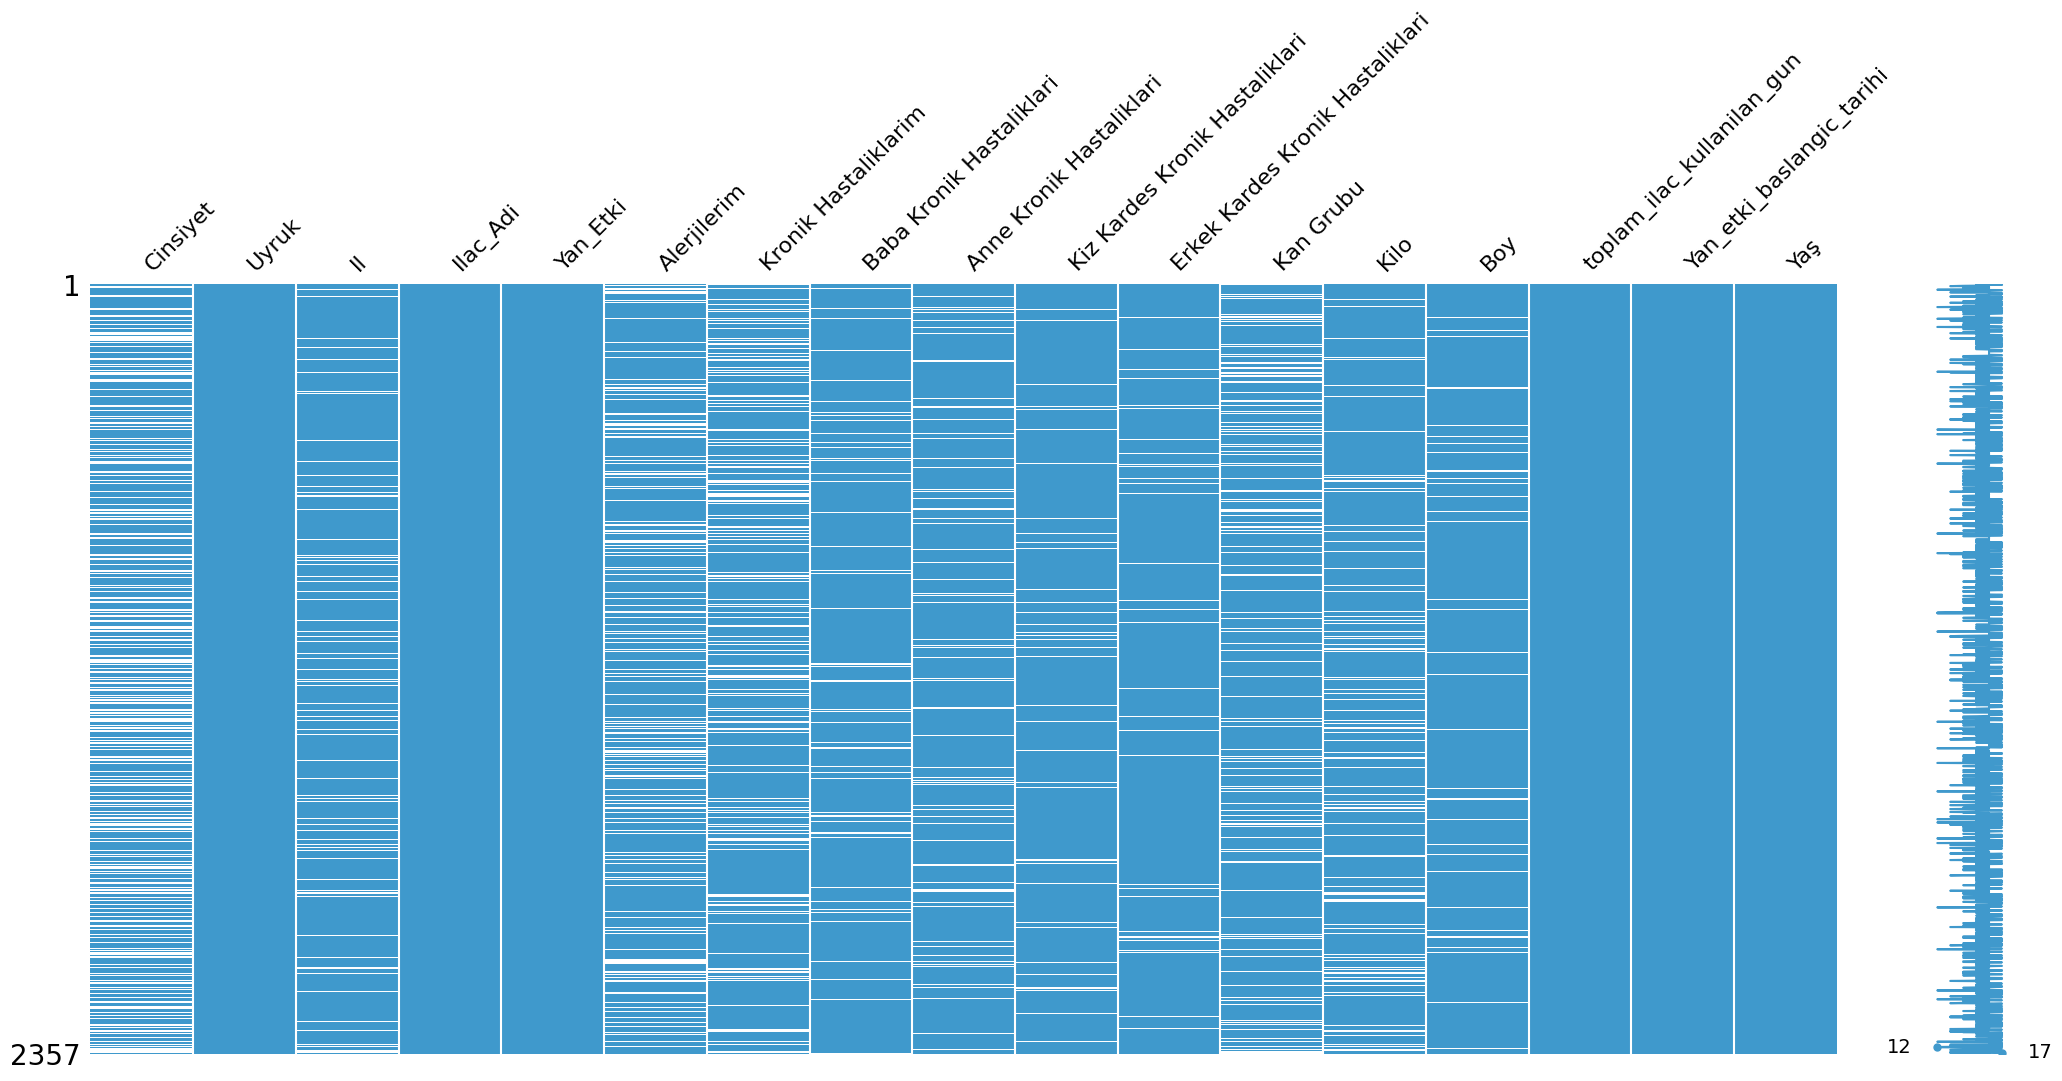

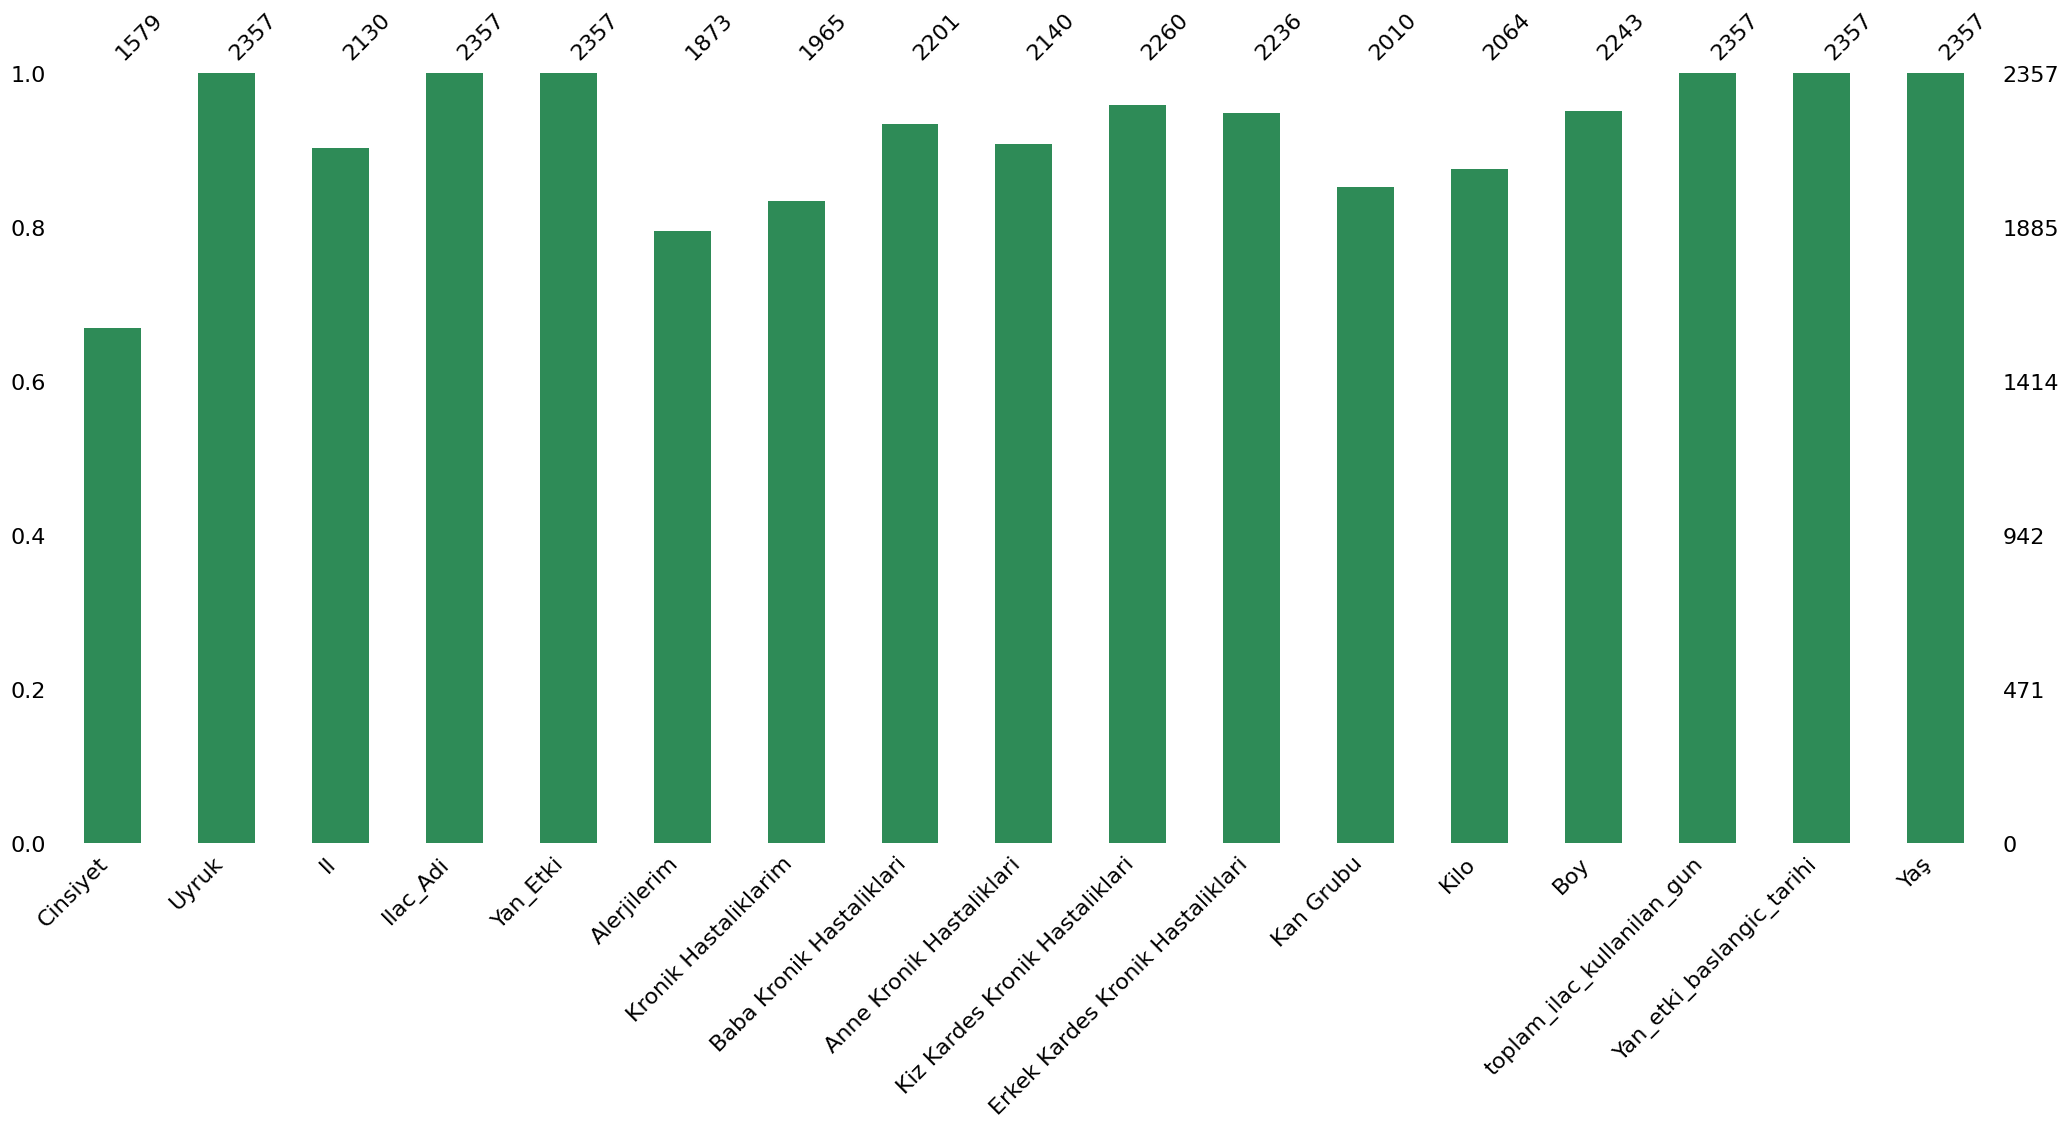

In [32]:
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt

custom_palette = sns.light_palette("seagreen", as_cmap=True)

msno.matrix(df, color=(0.25, 0.6, 0.8))
plt.show()

msno.bar(df, color='seagreen')
plt.show()


Eksik Verilerin Gözlenmesi

In [34]:
def missing_values_table (dataframe, na_name:False):
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]
    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys = ["n_miss", "ratio"])
    print(missing_df, end="\n")
    if na_name:
        return na_columns

missing_values_table(df, False)

                                  n_miss    ratio
Cinsiyet                             778 33.01000
Alerjilerim                          484 20.53000
Kronik Hastaliklarim                 392 16.63000
Kan Grubu                            347 14.72000
Kilo                                 293 12.43000
Il                                   227  9.63000
Anne Kronik Hastaliklari             217  9.21000
Baba Kronik Hastaliklari             156  6.62000
Erkek Kardes Kronik Hastaliklari     121  5.13000
Boy                                  114  4.84000
Kiz Kardes Kronik Hastaliklari        97  4.12000


Dtype = object olan sütünların boş değerlerini "Bilinmiyor" İle Dolduralım

In [35]:
def fill_object_na_with_bilinmiyor(dataframe):
    """
    DataFrame'deki dtype'ı 'object' olan sütunlardaki eksik değerlere 'Bilinmiyor' atar.

    Parameters:
    dataframe: pd.DataFrame
        İşlem yapılacak veri seti.

    Returns:
    dataframe: pd.DataFrame
        Eksik değerlere 'Bilinmiyor' atanmış veri seti.
    """
    # dtype'ı object olan sütunları seç
    object_columns = dataframe.select_dtypes(include=['object']).columns

    dataframe[object_columns] = dataframe[object_columns].fillna('Bilinmiyor')

    return dataframe


df = fill_object_na_with_bilinmiyor(df)


df.isnull().sum()


,0
Cinsiyet,0
Uyruk,0
Il,0
Ilac_Adi,0
Yan_Etki,0
Alerjilerim,0
Kronik Hastaliklarim,0
Baba Kronik Hastaliklari,0
Anne Kronik Hastaliklari,0
Kiz Kardes Kronik Hastaliklari,0


Sayısal olup, null değerleri olanları median ile dolduralım

In [36]:
def fill_numeric_na_with_median(dataframe):
    """
    DataFrame'deki sayısal sütunlardaki eksik değerlere medyan değerlerini atar.

    Parameters:
    dataframe: pd.DataFrame
        İşlem yapılacak veri seti.

    Returns:
    dataframe: pd.DataFrame
        Sayısal sütunlardaki eksik değerleri medyan ile doldurulmuş veri seti.
    """

    numeric_columns = dataframe.select_dtypes(include=['float64', 'int64']).columns
    dataframe[numeric_columns] = dataframe[numeric_columns].fillna(dataframe[numeric_columns].median())

    return dataframe


df = fill_numeric_na_with_median(df)


df.isnull().sum()  # Eksik değer olup olmadığını kontrol etmek için


,0
Cinsiyet,0
Uyruk,0
Il,0
Ilac_Adi,0
Yan_Etki,0
Alerjilerim,0
Kronik Hastaliklarim,0
Baba Kronik Hastaliklari,0
Anne Kronik Hastaliklari,0
Kiz Kardes Kronik Hastaliklari,0


Artık veri setimizde eksik değer yok.

Görselleştirme

Numeric sutunların görselleştirilmesi

count   2357.00000
mean      81.12940
std       17.45228
min       50.00000
5%        52.00000
10%       55.00000
20%       64.00000
30%       70.00000
40%       80.40000
50%       83.00000
60%       86.00000
70%       91.00000
80%       97.00000
90%      107.00000
99%      110.00000
max      110.00000
Name: Kilo, dtype: float64


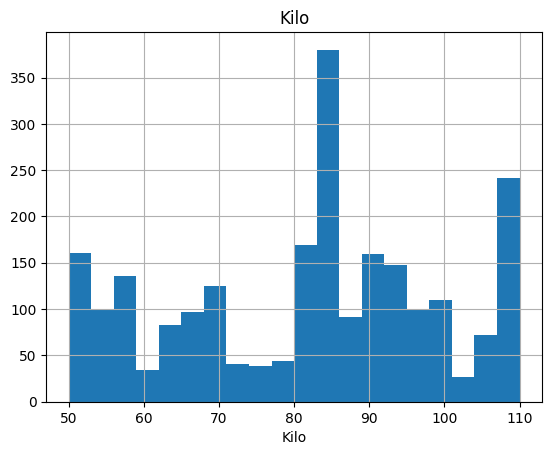

count   2357.00000
mean     174.70429
std       16.11465
min      145.00000
5%       147.00000
10%      150.00000
20%      158.00000
30%      165.00000
40%      172.00000
50%      176.00000
60%      181.00000
70%      184.00000
80%      189.00000
90%      197.00000
99%      203.00000
max      203.00000
Name: Boy, dtype: float64


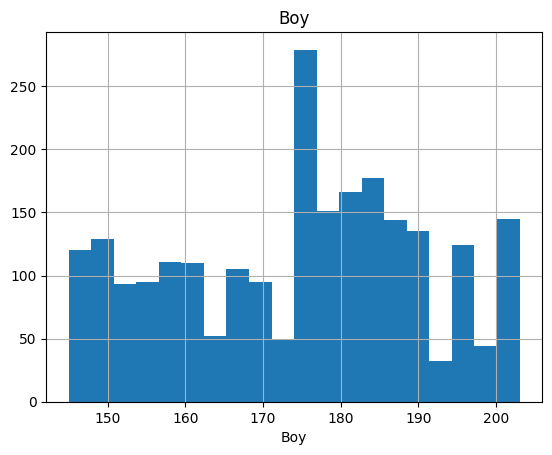

count   2357.00000
mean      62.23462
std        6.57661
min       47.00000
5%        51.00000
10%       53.00000
20%       56.00000
30%       59.00000
40%       61.00000
50%       62.00000
60%       64.00000
70%       66.00000
80%       68.00000
90%       71.00000
99%       76.00000
max       77.00000
Name: toplam_ilac_kullanilan_gun, dtype: float64


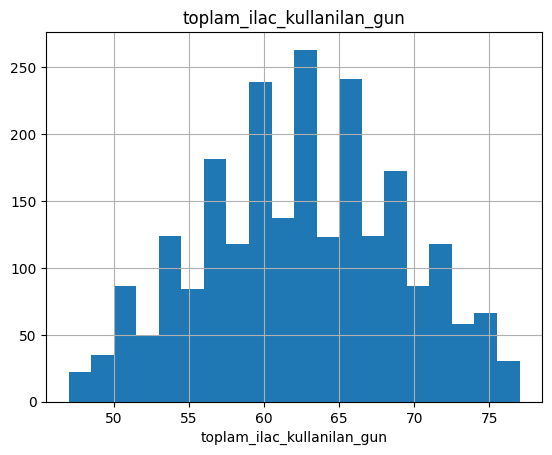

count   2357.00000
mean      33.81884
std        7.38125
min       18.00000
5%        22.00000
10%       24.00000
20%       27.00000
30%       29.00000
40%       31.00000
50%       34.00000
60%       36.00000
70%       38.00000
80%       41.00000
90%       44.00000
99%       49.00000
max       49.00000
Name: Yan_etki_baslangic_tarihi, dtype: float64


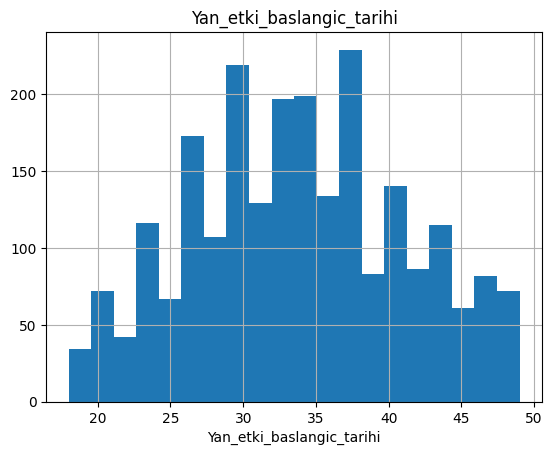

count   2357.00000
mean      49.36487
std       20.07175
min       13.00000
5%        18.00000
10%       22.00000
20%       28.00000
30%       35.00000
40%       42.00000
50%       51.00000
60%       56.00000
70%       63.00000
80%       69.00000
90%       78.40000
99%       84.00000
max       85.00000
Name: Yaş, dtype: float64


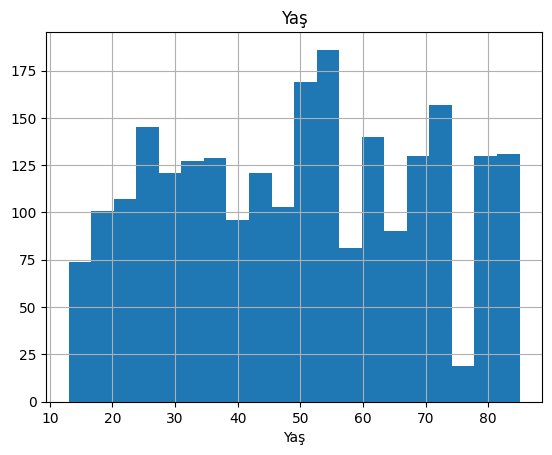

In [37]:
for col in num_cols:
    num_summary(df, col, plot=True)

categoric sutunların görselleştirilmesi

observations: 2357
variables: 17
cat_cols: 4
num_cols: 5
cat_but_car: 8 cat_but_car name: ['Ilac_Adi', 'Yan_Etki', 'Alerjilerim', 'Kronik Hastaliklarim', 'Baba Kronik Hastaliklari', 'Anne Kronik Hastaliklari', 'Kiz Kardes Kronik Hastaliklari', 'Erkek Kardes Kronik Hastaliklari']
num_but_cat: 0 num_but_cat name: []


<ipython-input-38-51845c1a4959>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=dataframe[col], data=dataframe, palette='Set2')


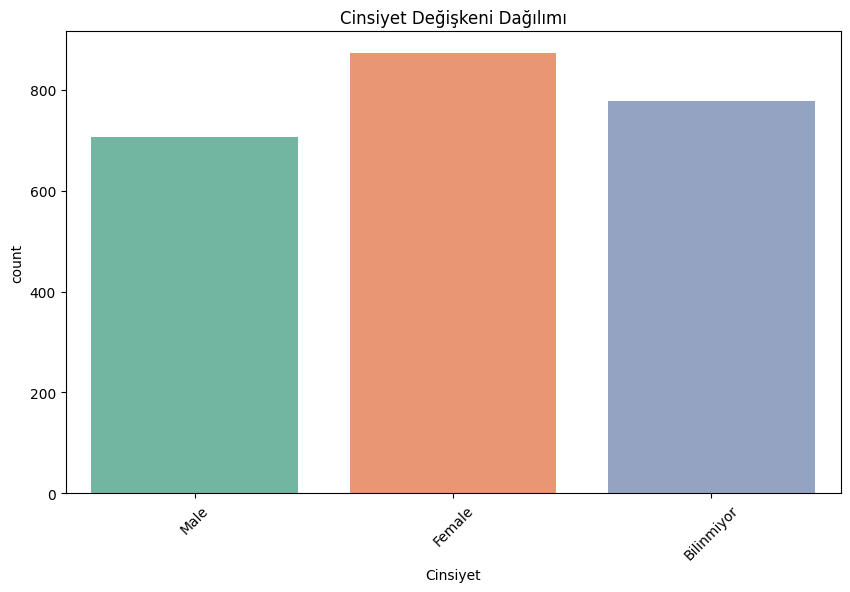

<ipython-input-38-51845c1a4959>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=dataframe[col], data=dataframe, palette='Set2')


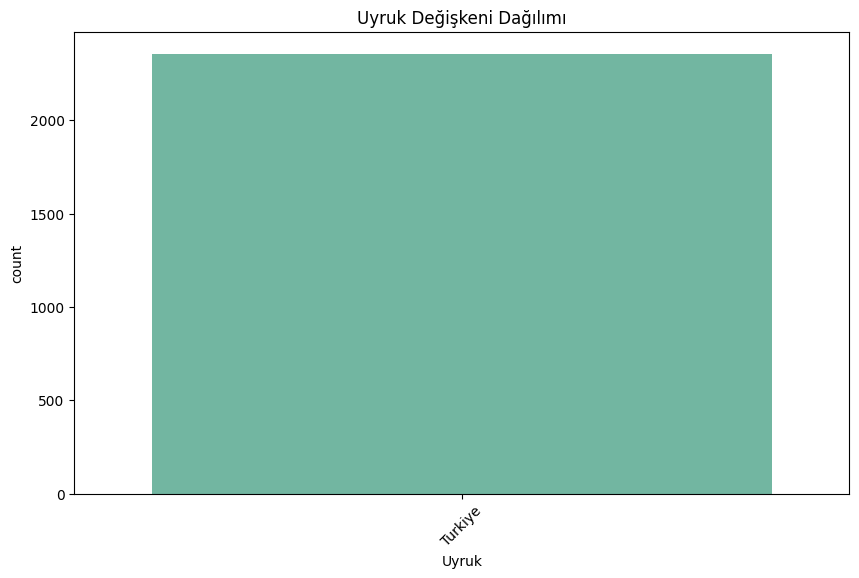

<ipython-input-38-51845c1a4959>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=dataframe[col], data=dataframe, palette='Set2')


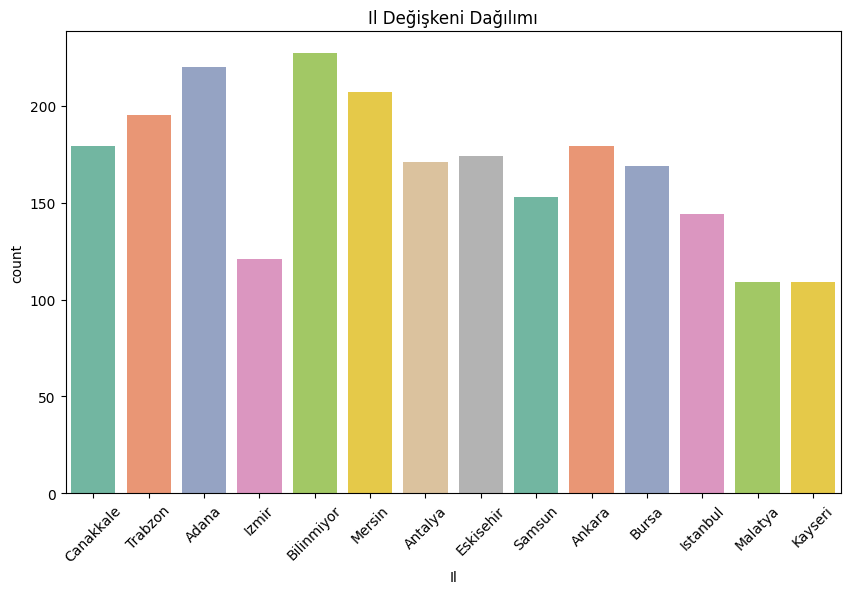

<ipython-input-38-51845c1a4959>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=dataframe[col], data=dataframe, palette='Set2')


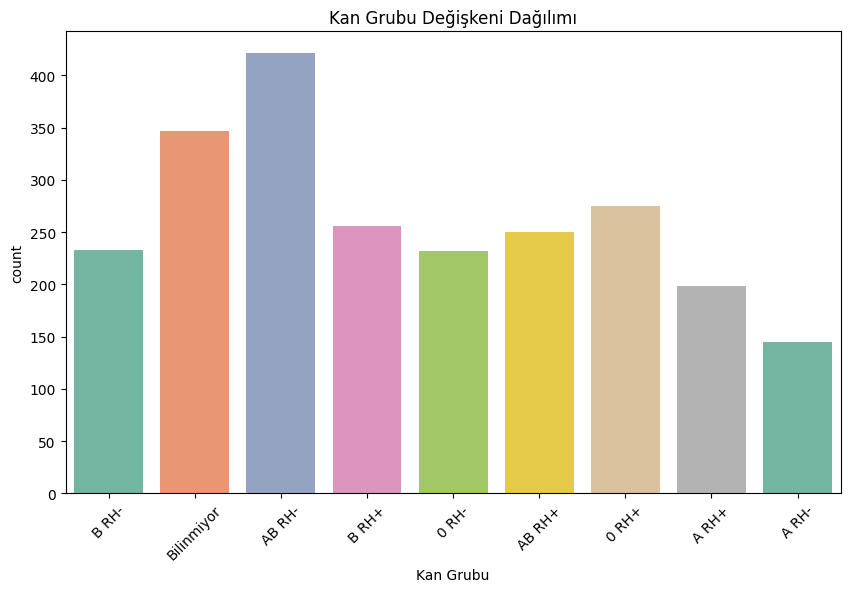

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_categorical_variables(dataframe, cat_cols):
    """
    Kategorik değişkenlerin bar grafiklerini oluşturur.

    Parameters:
    dataframe: pd.DataFrame
        Veri seti.
    cat_cols: list
        Kategorik sütunların isimlerinin listesi.
    """
    for col in cat_cols:
        plt.figure(figsize=(10, 6))
        sns.countplot(x=dataframe[col], data=dataframe, palette='Set2')
        plt.title(f'{col} Değişkeni Dağılımı')
        plt.xticks(rotation=45)
        plt.show()


cat_cols, num_cols, cat_but_car = grab_col_names(df)


plot_categorical_variables(df, cat_cols)


In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2357 entries, 0 to 2356
Data columns (total 17 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Cinsiyet                          2357 non-null   object 
 1   Uyruk                             2357 non-null   object 
 2   Il                                2357 non-null   object 
 3   Ilac_Adi                          2357 non-null   object 
 4   Yan_Etki                          2357 non-null   object 
 5   Alerjilerim                       2357 non-null   object 
 6   Kronik Hastaliklarim              2357 non-null   object 
 7   Baba Kronik Hastaliklari          2357 non-null   object 
 8   Anne Kronik Hastaliklari          2357 non-null   object 
 9   Kiz Kardes Kronik Hastaliklari    2357 non-null   object 
 10  Erkek Kardes Kronik Hastaliklari  2357 non-null   object 
 11  Kan Grubu                         2357 non-null   object 
 12  Kilo  

Yaş ve Kilo Arasındaki İlişki

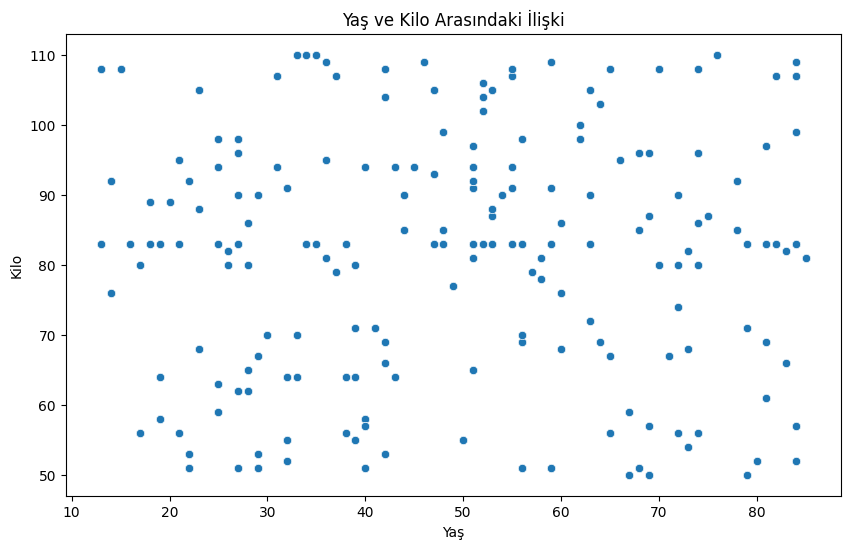

In [40]:
def plot_yas_kilo(dataframe):
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x='Yaş', y='Kilo', data=dataframe)
    plt.title('Yaş ve Kilo Arasındaki İlişki')
    plt.show()

plot_yas_kilo(df)


Kan Grubu ve Kronik Hastalıklar

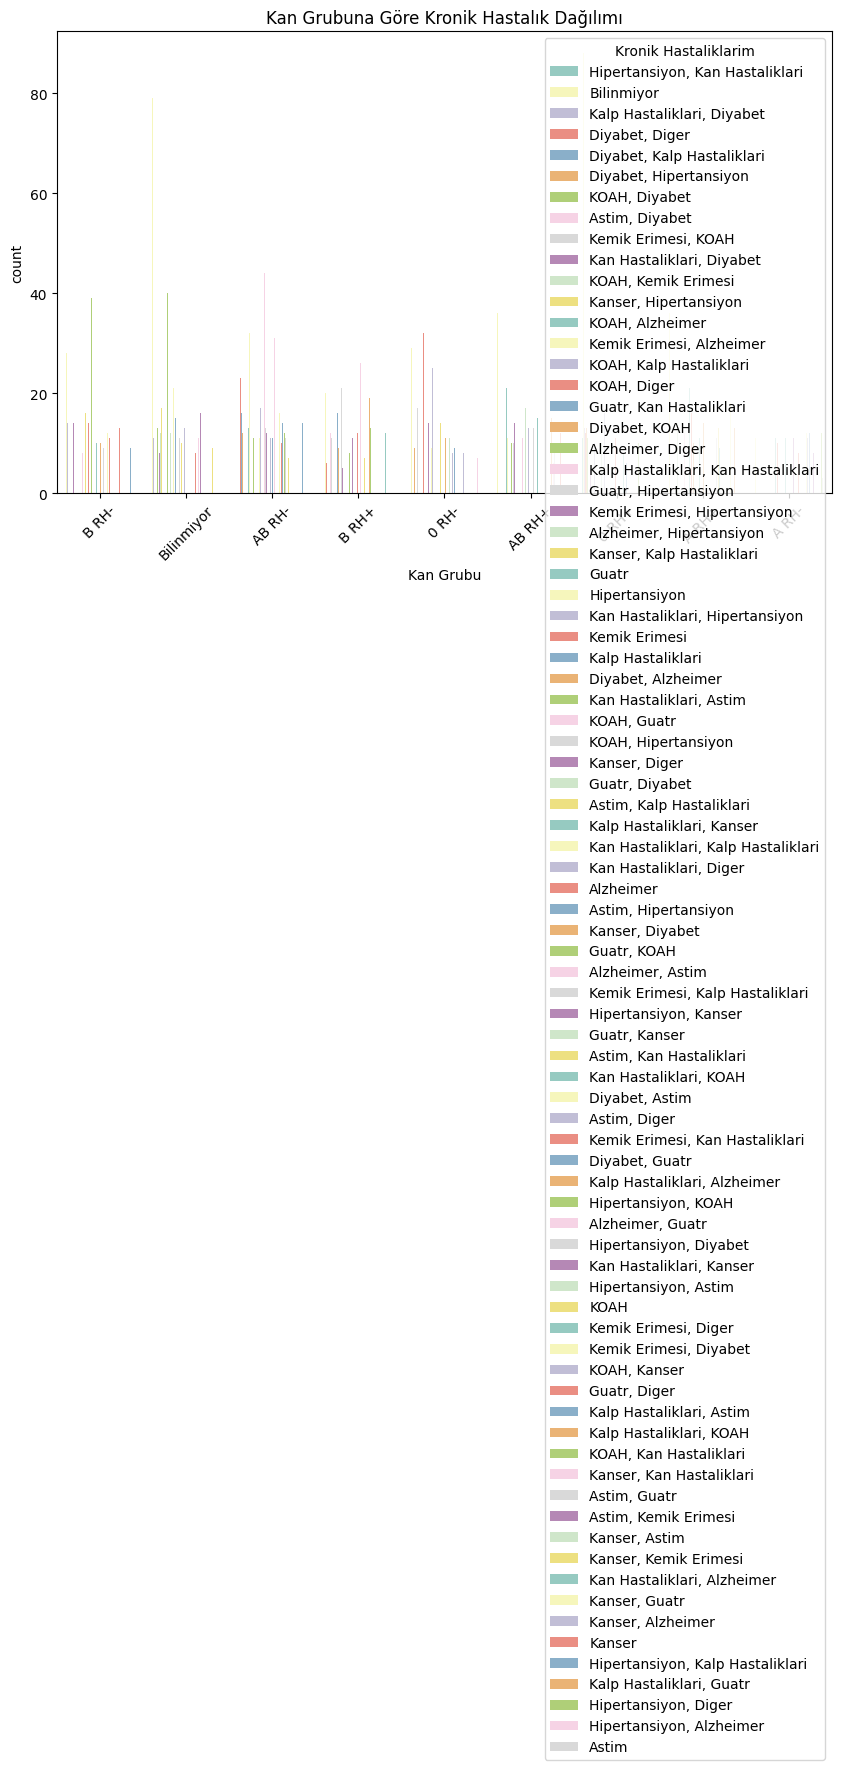

In [41]:
def plot_kan_grubu_kronik(dataframe):
    plt.figure(figsize=(10, 6))
    sns.countplot(x='Kan Grubu', hue='Kronik Hastaliklarim', data=dataframe, palette='Set3')
    plt.title('Kan Grubuna Göre Kronik Hastalık Dağılımı')
    plt.xticks(rotation=45)
    plt.show()

plot_kan_grubu_kronik(df)


Yaş Grupları ve Yan Etkilerin Gözetilmesi

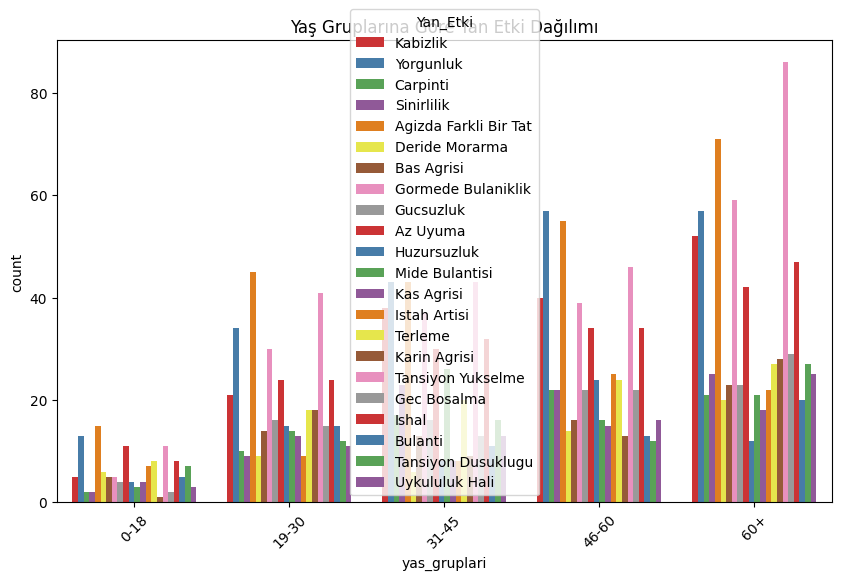

In [42]:
def plot_yas_gruplari_yan_etki(dataframe):
    bins = [0, 18, 30, 45, 60, 100]
    labels = ['0-18', '19-30', '31-45', '46-60', '60+']
    dataframe['yas_gruplari'] = pd.cut(dataframe['Yaş'], bins=bins, labels=labels)

    plt.figure(figsize=(10, 6))
    sns.countplot(x='yas_gruplari', hue='Yan_Etki', data=dataframe, palette='Set1')
    plt.title('Yaş Gruplarına Göre Yan Etki Dağılımı')
    plt.xticks(rotation=45)
    plt.show()

plot_yas_gruplari_yan_etki(df)


Cinsiyet ve İlaç Kullanılan Gün

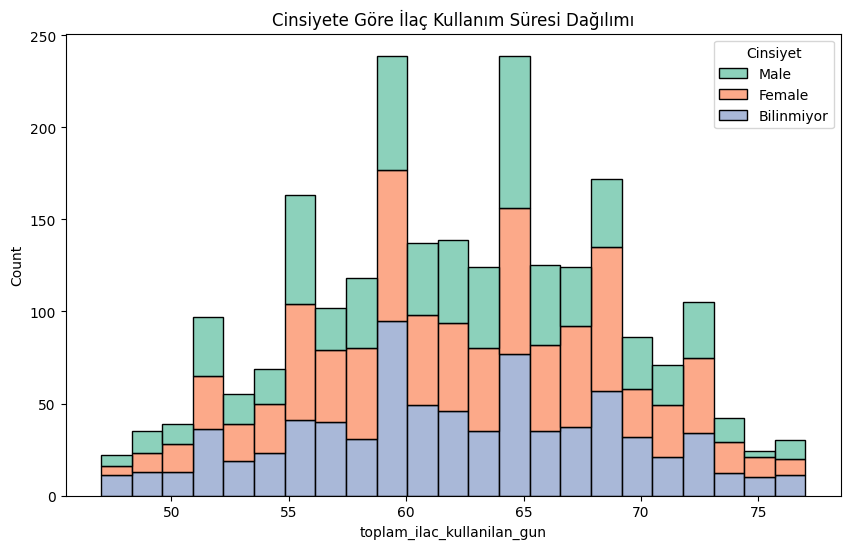

In [43]:
def plot_cinsiyet_ilac_suresi_histogram(dataframe):
    plt.figure(figsize=(10, 6))
    sns.histplot(data=dataframe, x='toplam_ilac_kullanilan_gun', hue='Cinsiyet', multiple='stack', palette='Set2')
    plt.title('Cinsiyete Göre İlaç Kullanım Süresi Dağılımı')
    plt.show()

plot_cinsiyet_ilac_suresi_histogram(df)


Kronik Hastalığı Olanlarda Yan Etki Dağılımı

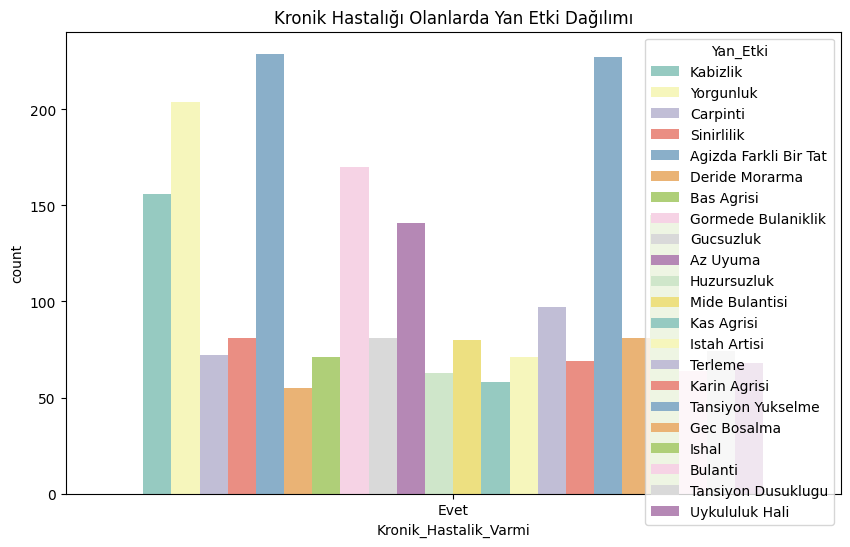

In [44]:
def plot_kronik_yan_etki(dataframe):
    dataframe['Kronik_Hastalik_Varmi'] = dataframe['Kronik Hastaliklarim'].apply(lambda x: 'Evet' if x != 'Yok' else 'Hayır')

    plt.figure(figsize=(10, 6))
    sns.countplot(x='Kronik_Hastalik_Varmi', hue='Yan_Etki', data=dataframe, palette='Set3')
    plt.title('Kronik Hastalığı Olanlarda Yan Etki Dağılımı')
    plt.show()

plot_kronik_yan_etki(df)


İllere Göre Yan Etki Dağılımı

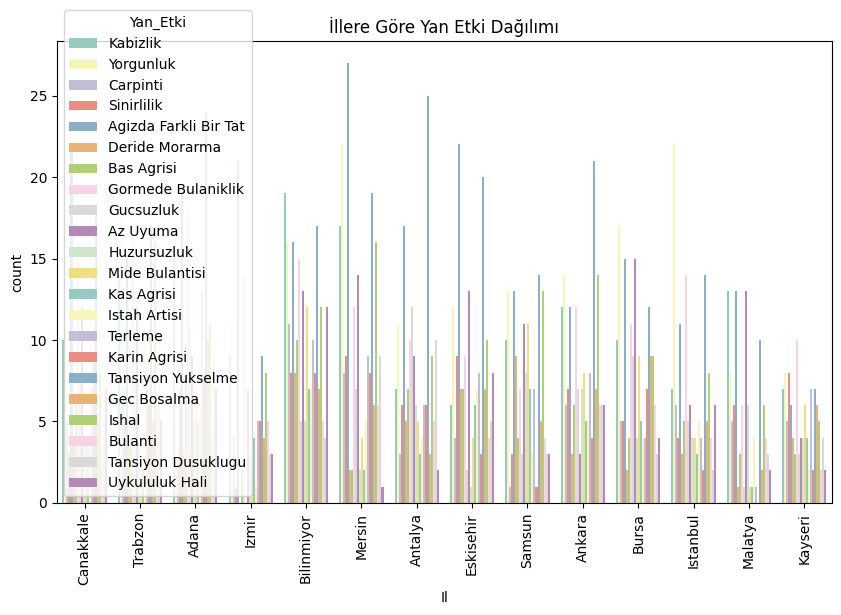

In [45]:
def plot_il_yan_etki(dataframe):
    plt.figure(figsize=(10, 6))
    sns.countplot(x='Il', hue='Yan_Etki', data=dataframe, palette='Set3')
    plt.title('İllere Göre Yan Etki Dağılımı')
    plt.xticks(rotation=90)
    plt.show()

plot_il_yan_etki(df)


Korelasyon Haritası

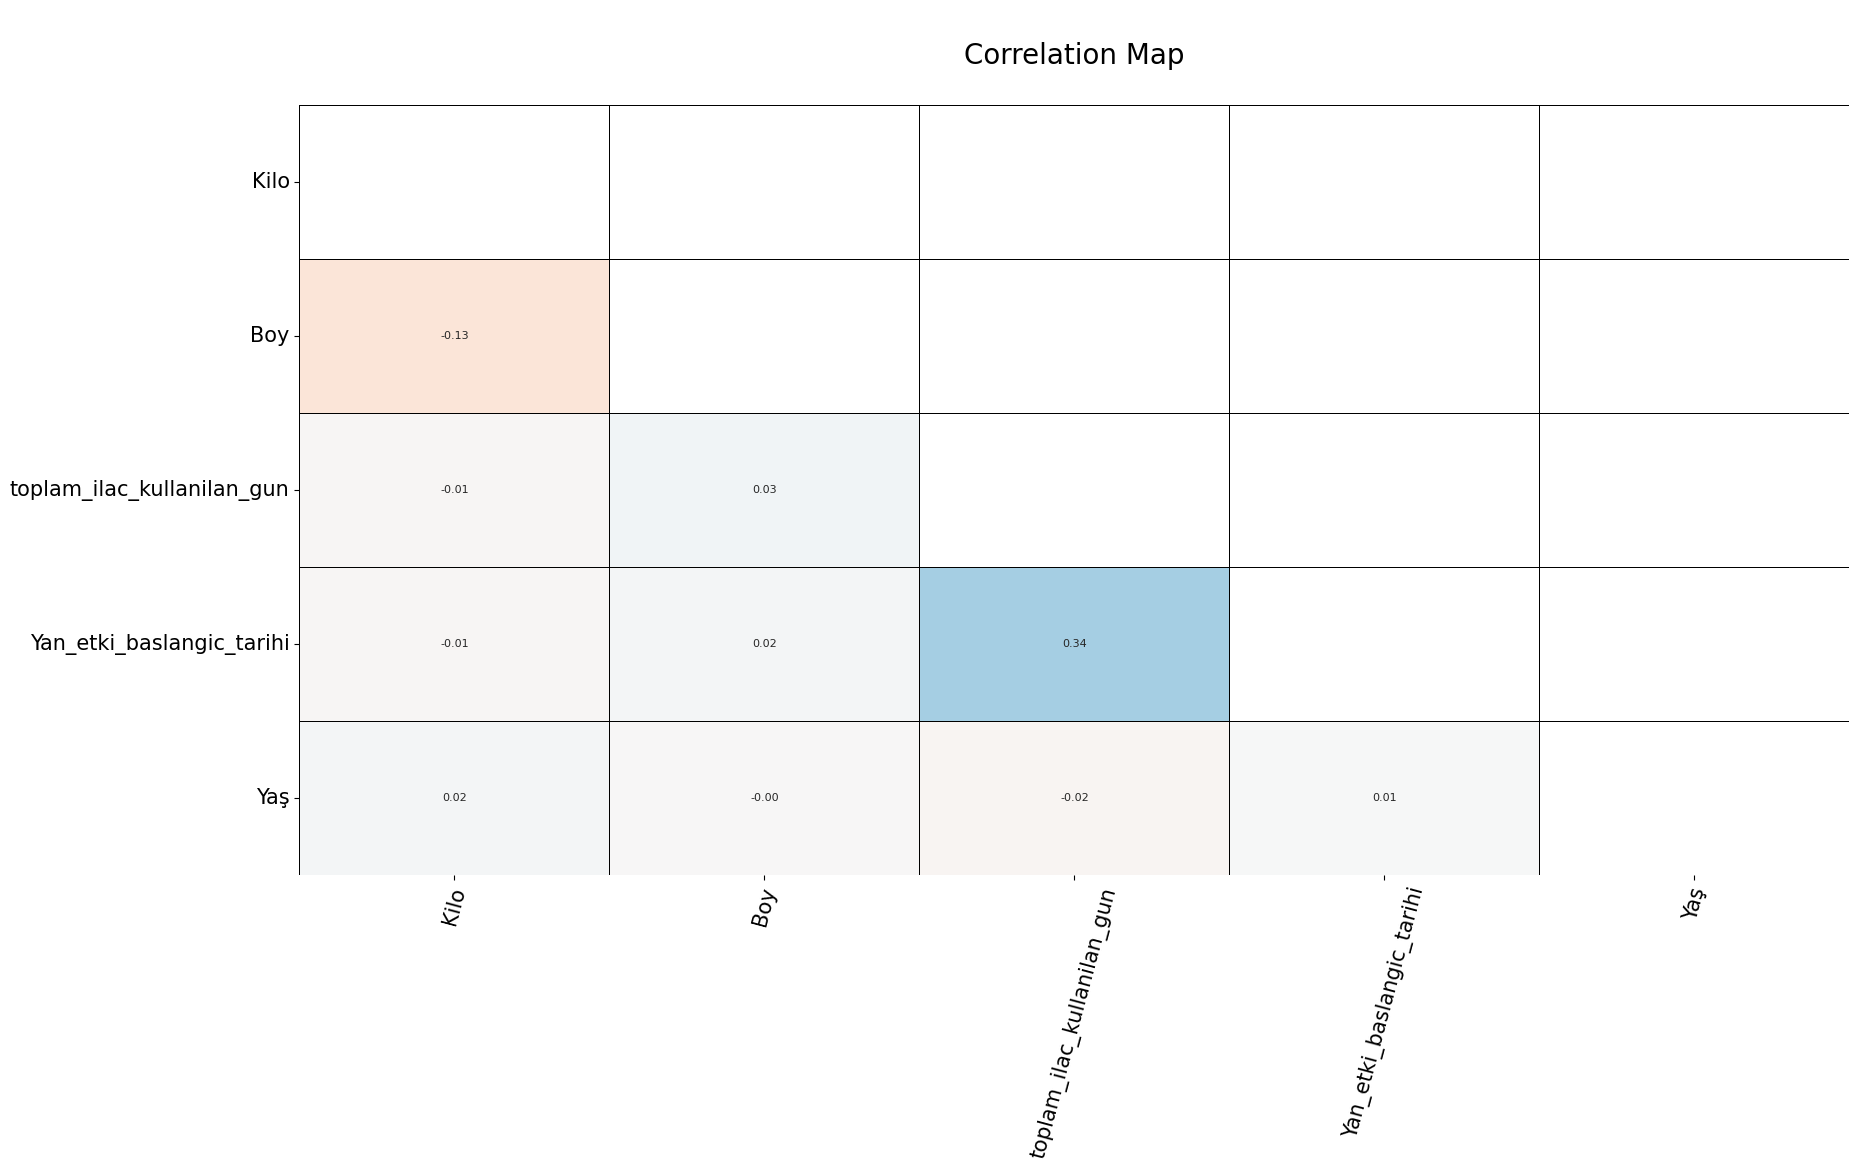

In [65]:
numeric_df = df.select_dtypes(include=['float64', 'int64'])


def corr_map(df, width=14, height=6, annot_kws=15):
    mtx = np.triu(df.corr())
    f, ax = plt.subplots(figsize=(width, height))
    sns.heatmap(df.corr(),
                annot=True,
                fmt=".2f",
                ax=ax,
                vmin=-1,
                vmax=1,
                cmap="RdBu",
                mask=mtx,
                linewidth=0.4,
                linecolor="black",
                cbar=False,
                annot_kws={"size": annot_kws})
    plt.yticks(rotation=0, size=15)
    plt.xticks(rotation=75, size=15)
    plt.title('\nCorrelation Map\n', size=20)
    plt.show()


corr_map(numeric_df, width=20, height=10, annot_kws=8)

İlaç - Cinsiyet Kırılımında Ortalama Yaş, İlaç Kullanım Süresi ve Yan Etki Süresi:

In [46]:
def pivot_ilac_cinsiyet(df):
    pivot_table = df.pivot_table(index=['Ilac_Adi', 'Cinsiyet'],
                                 values=['Yaş', 'toplam_ilac_kullanilan_gun', 'Yan_etki_baslangic_tarihi'],
                                 aggfunc='mean')
    return pivot_table

pivot_ilac_cinsiyet(df)



Yan_etki_baslangic_tarihi      Yaş  toplam_ilac_kullanilan_gun
Ilac_Adi                    Cinsiyet                                                                  
Levomilnacipran             Bilinmiyor                   33.62500 52.62500                    61.87500
                            Female                       38.28571 52.71429                    65.28571
                            Male                         33.22222 53.77778                    65.88889
Mometasone furoate          Bilinmiyor                   32.75000 44.50000                    62.50000
                            Female                       32.50000 41.50000                    59.50000
...                                                           ...      ...                         ...
ziprasidone vial            Female                       27.00000 48.40000                    61.40000
                            Male                         27.33333 37.00000                    63.00000
zolpidem tablet, sublingual Bilinmiyor                   34.87500 53.25000                    65.75000
                            Female                       35.16667 57.66667                    64.66667
                            Male                         33.66667 63.66667                    56.00000

[451 rows x 3 columns]

Cinsiyet - Yaş Kırılımında Ortalama İlaç Kullanım Süresi ve Yan Etki Süresi:

In [47]:
def pivot_cinsiyet_yas(df):
    pivot_table = df.pivot_table(index=['Cinsiyet', 'Yaş'],
                                 values=['toplam_ilac_kullanilan_gun', 'Yan_etki_baslangic_tarihi'],
                                 aggfunc='mean')
    return pivot_table

pivot_cinsiyet_yas(df)

Yan_etki_baslangic_tarihi  toplam_ilac_kullanilan_gun
Cinsiyet   Yaş                                                       
Bilinmiyor 13                    30.00000                    64.00000
           19                    38.00000                    60.14286
           20                    38.90909                    65.09091
           21                    34.33333                    62.50000
           22                    32.80952                    59.52381
...                                   ...                         ...
Male       80                    34.41667                    61.16667
           81                    36.15385                    64.46154
           83                    35.14286                    60.57143
           84                    32.50000                    59.83333
           85                    34.38889                    61.11111

[131 rows x 2 columns]

Kan Grubu - Yaş - Kilo Kırılımında İlaç Kullanım Süresi ve Yan Etki Süresi:

In [48]:
def kan_grubu_yas_kilo_analysis(df):
    result = df.groupby(['Kan Grubu', 'Yaş', 'Kilo']).apply(
        lambda x: pd.Series({
            'Ortalama_Ilac_Kullanim_Suresi': x['toplam_ilac_kullanilan_gun'].mean(),
            'Ortalama_Yan_Etki_Suresi': x['Yan_etki_baslangic_tarihi'].mean()
        })
    )
    return result


kan_grubu_yas_kilo_analysis(df)


Ortalama_Ilac_Kullanim_Suresi  Ortalama_Yan_Etki_Suresi
Kan Grubu  Yaş Kilo                                                             
0 RH+      14  76.00000                       62.70000                  33.30000
           22  51.00000                       62.90909                  36.72727
           25  63.00000                       63.41667                  36.66667
               94.00000                       61.92857                  33.21429
           30  70.00000                       63.00000                  32.16667
...                                                ...                       ...
Bilinmiyor 72  56.00000                       61.08333                  34.75000
           78  85.00000                       61.00000                  35.37500
           83  82.00000                       62.90909                  36.27273
           84  57.00000                       61.18182                  36.72727
           85  81.00000                       61.11111                  34.38889

[194 rows x 2 columns]

Outlier Analizi

In [54]:
num_cols

['Kilo',
 'Boy',
 'toplam_ilac_kullanilan_gun',
 'Yan_etki_baslangic_tarihi',
 'Yaş']

In [55]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2357 entries, 0 to 2356
Data columns (total 19 columns):
 #   Column                            Non-Null Count  Dtype   
---  ------                            --------------  -----   
 0   Cinsiyet                          2357 non-null   object  
 1   Uyruk                             2357 non-null   object  
 2   Il                                2357 non-null   object  
 3   Ilac_Adi                          2357 non-null   object  
 4   Yan_Etki                          2357 non-null   object  
 5   Alerjilerim                       2357 non-null   object  
 6   Kronik Hastaliklarim              2357 non-null   object  
 7   Baba Kronik Hastaliklari          2357 non-null   object  
 8   Anne Kronik Hastaliklari          2357 non-null   object  
 9   Kiz Kardes Kronik Hastaliklari    2357 non-null   object  
 10  Erkek Kardes Kronik Hastaliklari  2357 non-null   object  
 11  Kan Grubu                         2357 non-null   object

In [77]:
import pandas as pd

def check_outlier(dataframe, col_name):
    if pd.api.types.is_numeric_dtype(dataframe[col_name]):
        low_limit, up_limit = outlier_thresholds(dataframe, col_name)
        return ((dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)).sum() > 0
    else:
        return False

for col in df.select_dtypes(include=["float64", "int64"]).columns:
    print(col, check_outlier(df, col))


Kilo False
Boy False
toplam_ilac_kullanilan_gun False
Yan_etki_baslangic_tarihi False
Yaş False


In [78]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

observations: 2357
variables: 19
cat_cols: 6
num_cols: 5
cat_but_car: 8 cat_but_car name: ['Ilac_Adi', 'Yan_Etki', 'Alerjilerim', 'Kronik Hastaliklarim', 'Baba Kronik Hastaliklari', 'Anne Kronik Hastaliklari', 'Kiz Kardes Kronik Hastaliklari', 'Erkek Kardes Kronik Hastaliklari']
num_but_cat: 1 num_but_cat name: ['yas_gruplari']


In [79]:
binary_col = [col for col in df[cat_cols].columns if df[col].nunique() == 2]

def label_encoder(dataframe, binary_col):
    labelencoder = LabelEncoder()
    dataframe[binary_col] = labelencoder.fit_transform(dataframe[binary_col])
    return dataframe

for col in binary_col:
    df = label_encoder(df, col)


Çoklu classa sahip kategorikler için one hot encoding uygulayalım

In [80]:
cat_cols = [col for col in cat_cols if col not in binary_col]
def one_hot_encoder(dataframe, categoric_cols, drop_first=False):
    dataframe = pd.get_dummies(dataframe, columns=categoric_cols, drop_first=drop_first, dtype=int)
    return dataframe

df = one_hot_encoder(df,cat_cols,drop_first=True)


In [81]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2357 entries, 0 to 2356
Data columns (total 40 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Ilac_Adi                          2357 non-null   object 
 1   Yan_Etki                          2357 non-null   object 
 2   Alerjilerim                       2357 non-null   object 
 3   Kronik Hastaliklarim              2357 non-null   object 
 4   Baba Kronik Hastaliklari          2357 non-null   object 
 5   Anne Kronik Hastaliklari          2357 non-null   object 
 6   Kiz Kardes Kronik Hastaliklari    2357 non-null   object 
 7   Erkek Kardes Kronik Hastaliklari  2357 non-null   object 
 8   Kilo                              2357 non-null   float64
 9   Boy                               2357 non-null   float64
 10  toplam_ilac_kullanilan_gun        2357 non-null   int64  
 11  Yan_etki_baslangic_tarihi         2357 non-null   int64  
 12  Yaş   

In [82]:
df.head()

,Ilac_Adi,Yan_Etki,Alerjilerim,Kronik Hastaliklarim,Baba Kronik Hastaliklari,Anne Kronik Hastaliklari,Kiz Kardes Kronik Hastaliklari,Erkek Kardes Kronik Hastaliklari,Kilo,Boy,toplam_ilac_kullanilan_gun,Yan_etki_baslangic_tarihi,Yaş,Cinsiyet_Female,Cinsiyet_Male,Il_Ankara,Il_Antalya,Il_Bilinmiyor,Il_Bursa,Il_Canakkale,Il_Eskisehir,Il_Istanbul,Il_Izmir,Il_Kayseri,Il_Malatya,Il_Mersin,Il_Samsun,Il_Trabzon,Kan Grubu_0 RH-,Kan Grubu_A RH+,Kan Grubu_A RH-,Kan Grubu_AB RH+,Kan Grubu_AB RH-,Kan Grubu_B RH+,Kan Grubu_B RH-,Kan Grubu_Bilinmiyor,yas_gruplari_19-30,yas_gruplari_31-45,yas_gruplari_46-60,yas_gruplari_60+
0,trifluoperazine,Kabizlik,Ceviz,"Hipertansiyon, Kan Hastaliklari","Guatr, Hipertansiyon",KOAH,"Kemik Erimesi, Kalp Hastaliklari","Kemik Erimesi, Guatr",103.00000,191.00000,54,41,64,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
1,fluphenazine hcl,Yorgunluk,Toz,Bilinmiyor,"Guatr, Diger","Hipertansiyon, Kalp Hastaliklari",,"KOAH, Diyabet",81.00000,181.00000,58,25,85,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1
2,warfarin sodium,Carpinti,Muz,"Kalp Hastaliklari, Diyabet","Diyabet, KOAH","Kemik Erimesi, Diyabet","Diyabet, Kemik Erimesi",Diger,93.00000,158.00000,60,24,47,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
3,valproic acid,Sinirlilik,Pancar,"Diyabet, Diger","Kalp Hastaliklari, Diger",Bilinmiyor,Astim,"Kalp Hastaliklari, Kanser",83.00000,165.00000,67,35,47,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
4,carbamazepine extended release,Agizda Farkli Bir Tat,Bilinmiyor,"Diyabet, Kalp Hastaliklari","Alzheimer, Hipertansiyon","Kan Hastaliklari, Kemik Erimesi","Diyabet, Diger","Alzheimer, Hipertansiyon",99.00000,172.00000,52,30,48,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
